In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno
import numpy as np
import matplotlib.pyplot as plt

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from dustextinction import (
    get_gal_extinction_from_radec,
    get_xredden_template_model,
)
from utils import (
    get_dataset_energy_edges
)

from gammapy.datasets import Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import Models

## Datasets and models

In [2]:
basedir = os.path.abspath("../../../")
datasetdir  = f"{basedir}/UVOT/MJD60384/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
uvot_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")

# Since we only have one filter, instead of getting leaving a free LP model, use Liverpool's constraint.
uvot_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
uvot_datasets.models[0].parameters['alpha'].value = 1.900
uvot_datasets.models[0].parameters['beta'].value  = 0.313
uvot_datasets.models[0].parameters['alpha'].frozen = True
uvot_datasets.models[0].parameters['beta'].frozen  = True

extinction_model = get_xredden_template_model(f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",
                                              srcname='OP313')

extinction_model.parameters['ebv'].frozen = True
uvot_datasets.models[0].spectral_model *= extinction_model


/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [3]:
uvot_datasets.models[0].spectral_model

## Fit and flux points

In [4]:
# Define a fit
uvot_only_fit    = Fit(store_trace=True)
uvot_only_result = uvot_only_fit.run(uvot_datasets)
print(uvot_only_result)
# we make a copy here for later comparisons
uvot_only_model = uvot_datasets.models.copy()
# spectral points
energy_edge_pairs = [get_dataset_energy_edges(d) for d in uvot_datasets]
uvot_only_fpe     = [FluxPointsEstimator(energy_edges=edges, source="OP313") for edges in energy_edge_pairs]
uvot_only_points  = [uvot_only_fpe[k].run(datasets=d) for k,d in enumerate(uvot_datasets)]

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 21
	total stat : 0.00

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



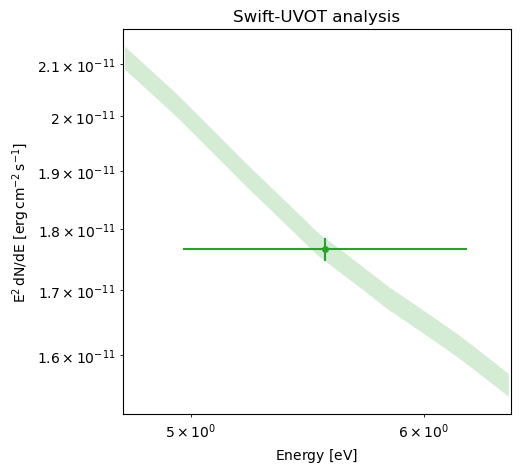

In [5]:
plt.figure(figsize=(5, 5),dpi=100)

emin = min([min(pair) for pair in energy_edge_pairs])
emax = max([max(pair) for pair in energy_edge_pairs])

ax = uvot_only_model['OP313'].spectral_model.plot_error(
    [emin.to('eV'),emax.to('eV')],
    facecolor='C2',
    sed_type='e2dnde')

for point in uvot_only_points:
    point.plot(
        ax=ax, color="C2", sed_type='e2dnde',
    )

ax.set_xlim(emin,emax)
ax.set_title('Swift-UVOT analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')
!mkdir -p {basedir}/Figures/MJD60384/Swift-UVOT/
plt.savefig(f'{basedir}/Figures/MJD60384/Swift-UVOT/BestFit-Swift-UVOT.pdf',bbox_inches='tight')